## Figure 5

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

from pytorch_lightning import utilities as pl_utils
from pytorch_lightning.trainer.trainer import Trainer
from pytorch_lightning.plugins import DDPPlugin
import torch
import pathlib
from functools import partial
import sys, glob
import numpy as np

sys.path.append('..')
sys.path.append('../deep-learning-base')
sys.path.append('../deep-learning-base/training')
sys.path.append('../deep-learning-base/datasets')
sys.path.append('../partially_inverted_reps')

import plot_helper as plt_hp
import output as out
from training import LitProgressBar, NicerModelCheckpointing
import training.finetuning as ft
import architectures as arch
from architectures.callbacks import LightningWrapper, LinearEvalWrapper
from attack.callbacks import AdvCallback
from data_modules import DATA_MODULES
import dataset_metadata as dsmd
from partial_loss import PartialInversionLoss, PartialInversionRegularizedLoss
from __init__ import DATA_PATH_IMAGENET, DATA_PATH, SERVER_PROJECT_PATH, DATA_PATH_FLOWERS_PETS

/NS/twitter_archive2/work/vnanda/minconda3/envs/dl_base/lib/python3.7/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
CHECKPOINT_PATHS = {
    'resnet50': {
        'nonrob': '',
        'robustl2eps3': '/NS/robustness_3/work/vnanda/adv-robustness/logs/'\
                        'robust_imagenet/eps3/resnet-50-l2-eps3.ckpt'},
    'resnet50_ff8': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/'\
                  'checkpoints/imagenet1k/r50_mrl0_e0_ff8.pt'},
    'resnet50_ff16': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/'\
                  'checkpoints/imagenet1k/r50_mrl0_e0_ff16.pt'},
    'resnet50_ff32': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/'\
                  'checkpoints/imagenet1k/r50_mrl0_e0_ff32.pt'},
    'resnet50_ff64': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/'\
                  'checkpoints/imagenet1k/r50_mrl0_e0_ff64.pt'},
    'resnet50_ff128': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/'\
                  'checkpoints/imagenet1k/r50_mrl0_e0_ff128.pt'},
    'resnet50_ff256': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/'\
                  'checkpoints/imagenet1k/r50_mrl0_e0_ff256.pt'},
    'resnet50_ff512': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/'\
                  'checkpoints/imagenet1k/r50_mrl0_e0_ff512.pt'},
    'resnet50_ff1024': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/'\
                  'checkpoints/imagenet1k/r50_mrl0_e0_ff1024.pt'},
    'wide_resnet50_2': {
        'robustl2eps3': '/NS/robustness_3/work/vnanda/adv-robustness/logs/'\
                        'robust_imagenet/eps3/wideresnet-50-2-l2-eps3.ckpt'},
    'wide_resnet50_4': {
        'robustl2eps3': '/NS/robustness_3/work/vnanda/adv-robustness/logs/'\
                        'robust_imagenet/eps3/wideresnet-50-4-l2-eps3.ckpt'}
}

In [3]:
SEED = 2
NUM_NODES = 1
DEVICES = 1
BASE_DIR = f"{pathlib.Path('.').parent.resolve()}/checkpoints"

FINETUNE_MODE = 'random'
FINETUNE_BS = 256
EVAL_BATCH_SIZE = 100

In [4]:
def save_predictions(model_path, out):
    preds_path = f'{model_path.split(".ckpt")[0]}.pred'
    torch.save({'pred': out[0].detach().cpu(), 'gt': out[2].detach().cpu()}, preds_path)

def load_predictions(model_path):
    preds_path = f'{model_path.split(".ckpt")[0]}.pred'
    if os.path.exists(preds_path):
        return torch.load(preds_path)

def accuracy(gt, pred):
    pred = torch.argmax(pred, 1)
    return torch.sum(gt == pred) / len(gt)


def get_test_acc(model, source_dataset, finetuning_dataset, checkpoint_path, model_path, seed, fraction):
    state_dict = torch.load(model_path)
    dm = DATA_MODULES[finetuning_dataset](
        data_dir=DATA_PATH_IMAGENET if 'imagenet' in finetuning_dataset else \
            DATA_PATH_FLOWERS_PETS if finetuning_dataset in ['flowers','oxford-iiit-pets'] else DATA_PATH,
        transform_train=dsmd.TRAIN_TRANSFORMS_TRANSFER_DEFAULT(224),
        transform_test=dsmd.TEST_TRANSFORMS_DEFAULT(224),
        batch_size=EVAL_BATCH_SIZE)
    dm.init_remaining_attrs(source_dataset)

    ## assign mean and std from source dataset
    m1 = arch.create_model(model, source_dataset, pretrained=True,
                           checkpoint_path=checkpoint_path, seed=SEED, 
                           num_classes=dsmd.DATASET_PARAMS[source_dataset]['num_classes'],
                           callback=partial(LightningWrapper, 
                                            dataset_name=source_dataset,
                                            inference_kwargs={'with_latent': True}),
                           loading_function_kwargs={'strict': False}) # some final layers are strange
    new_layer = ft.setup_model_for_finetuning(
        m1.model, 
        dsmd.DATASET_PARAMS[finetuning_dataset]['num_classes'],
        FINETUNE_MODE, fraction, seed)
    print (new_layer.__dict__)
    linear_layer = list(m1.model.named_modules())[-1][1]
    linear_layer.load_state_dict({k.split('.')[-1]:v \
                                  for k,v in state_dict['state_dict'].items()}, strict=True)
    if hasattr(new_layer, 'neuron_indices') and 'neuron_indices' in state_dict:
        assert torch.all(new_layer.neuron_indices == state_dict['neuron_indices'])
    pl_utils.seed.seed_everything(seed, workers=True)

    trainer = Trainer(accelerator='gpu', 
                      devices=DEVICES,
                      num_nodes=NUM_NODES,
                      log_every_n_steps=1,
                      auto_select_gpus=True, 
                      deterministic=True,
                      check_val_every_n_epoch=1,
                      num_sanity_val_steps=0,
                      callbacks=[
                        LitProgressBar(['loss', 
                                        'running_test_acc'])])

    out = trainer.predict(m1, dataloaders=[dm.test_dataloader()])
    save_predictions(model_path, out)
    return accuracy(out[2], out[0])

In [5]:
def results(models_to_compare, source_dataset, ft_ds, append, FRACTIONS_OR_NUMBERS):
    plt_str = '== Finetuning results ==\n\n'
    model_to_fracwise_accs = {}
    for idx, model in enumerate(models_to_compare):
        plt_str += f'=== {model} - {append} - {ft_ds} ===\n\n'
        frac_wise_test_accs = {}
        if FRACTIONS_OR_NUMBERS[idx] is None:
            PARTIAL_FRACTIONS = sorted(
                list(set(
                    [float(x.split('/frac-')[1].split('-')[0]) for x in \
                            glob.glob(f'./checkpoints/{model}-base-'
                                      f'{source_dataset}-ft-{ft_ds}/'
                                      f'*-bs-256-{append}/*-topk=1.ckpt') \
                     if len(x.split('/frac-')[1].split('-')[0]) == 7 and \
                        'layer' not in x.split('/')[-1] and \
                        'pool' not in x.split('/')[-1] and \
                        'full-feature' not in x.split('/')[-1]]
                )))
        else:
            PARTIAL_FRACTIONS = FRACTIONS_OR_NUMBERS[idx]

        for frac in PARTIAL_FRACTIONS:
            if isinstance(frac, int):
                actual_fraction = frac / PARTIAL_FRACTIONS[-1]
            else:
                actual_fraction = frac
            model_paths = [x for x in glob.glob(f'{BASE_DIR}/{model}-base-{source_dataset}-ft-{ft_ds}/'
                                           f'frac-{actual_fraction:.5f}-mode-{FINETUNE_MODE}-seed-*-'
                                           f'ftmode-linear-lr-*-bs*-{append}/'
                                           '*-topk=1.ckpt') \
                           if 'layer' not in x.split('/')[-1] and \
                              'pool' not in x.split('/')[-1] and \
                              'full-feature' not in x.split('/')[-1]]
            for path in model_paths:
                pickled_preds = load_predictions(path)
                if pickled_preds is None:
                    acc = get_test_acc(model, source_dataset, ft_ds, 
                                       CHECKPOINT_PATHS[model][append], path, 
                                       int(path.split('-seed-')[1].split('-')[0]), actual_fraction).item()
                else:
                    acc = accuracy(pickled_preds['gt'], pickled_preds['pred'])
                
                if actual_fraction in frac_wise_test_accs:
                    frac_wise_test_accs[actual_fraction].append(acc)
                else:
                    frac_wise_test_accs[actual_fraction] = [acc]
        model_to_fracwise_accs[model] = frac_wise_test_accs

    x_vals = [sorted(list(model_to_fracwise_accs[model].keys())) for model in models_to_compare]
    plt_str += '{}\n\n'.format(plt_hp.get_wiki_link(plt_hp.line_plot(
        [[np.nanmean(model_to_fracwise_accs[model][f]) for f in sorted(model_to_fracwise_accs[model].keys())] \
             for model in models_to_compare], 
        'Fraction of neurons', 'Transfer Accuracy', ft_ds, 
        subfolder=source_dataset, 
        filename=f'{"-".join(models_to_compare)}_{ft_ds}_bs_{FINETUNE_BS}_{append}', 
        extension='png', x_vals=x_vals, 
        legend_vals=[m for m in models_to_compare], 
        vertical_line=None, colors=plt_hp.COLORS, 
        linestyles=['-'] * len(models_to_compare), 
        y_lims=(0.,1.), root_dir='.', paper_friendly_plots=True, 
        plot_inside=False, legend_location='best', savefig=True, 
        figsize=(10,6), marker=[True] * len(models_to_compare), 
        results_subfolder_name='width_comparison', grid_spacing=0.3, 
        y_err=[[np.nanstd(model_to_fracwise_accs[model][f]) \
                for f in sorted(model_to_fracwise_accs[model].keys())] for model in models_to_compare], 
        legend_ncol=3), SERVER_PROJECT_PATH, size=700))

    with open(f'./results/width_comparison/{source_dataset}/wiki_results-{model}.txt', 'w') as fp:
        fp.write(plt_str)
    out.upload_results(['{}/{}/{}'.format(plt_hp.RESULTS_FOLDER_NAME, 'width_comparison', source_dataset)], 
        'results', SERVER_PROJECT_PATH, '.png')

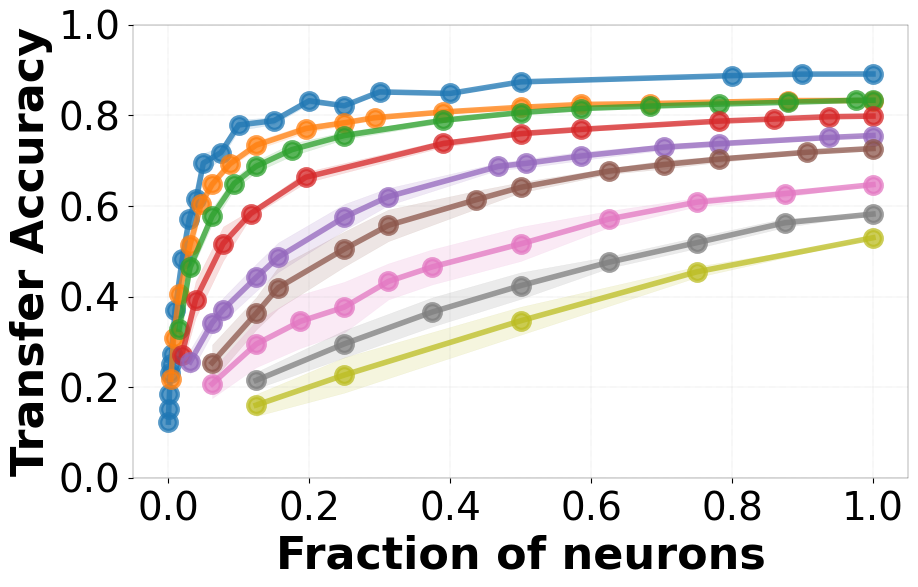

Uploading results in ['results/width_comparison/imagenet'] to contact.mpi-sws.org...
Uploading 12 files to server
copying results/width_comparison/imagenet/resnet50-resnet50_ff8-resnet50_ff16-resnet50_ff32-resnet50_ff64_cifar10_bs_256_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/width_comparison/imagenet/resnet50-resnet50_ff8-resnet50_ff16-resnet50_ff32-resnet50_ff64_cifar10_bs_256_nonrob.png
copying results/width_comparison/imagenet/resnet50-wide_resnet50_2-wide_resnet50_4_cifar10_bs_256_robustl2eps3.png to /home/vnanda/public_html/results/partially_inverted_reps/width_comparison/imagenet/resnet50-wide_resnet50_2-wide_resnet50_4_cifar10_bs_256_robustl2eps3.png
copying results/width_comparison/imagenet/resnet50-resnet50_ff8-resnet50_ff16-resnet50_ff32-resnet50_ff64-resnet50_ff128-resnet50_ff256-resnet50_ff512-resnet50_ff1024_cifar10_bs_256_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/width_comparison/imagenet/resnet50-resnet50_ff8-res

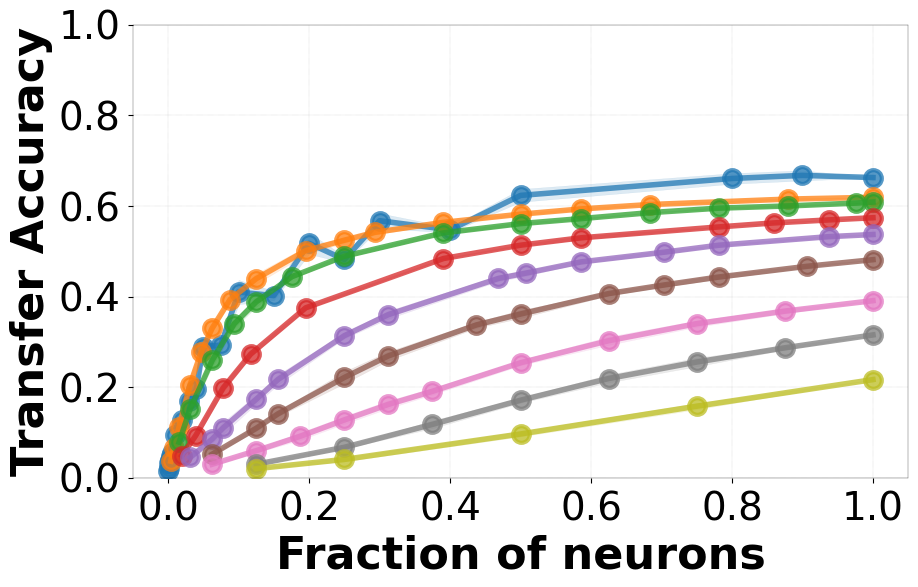

Uploading results in ['results/width_comparison/imagenet'] to contact.mpi-sws.org...
Uploading 12 files to server
copying results/width_comparison/imagenet/resnet50-resnet50_ff8-resnet50_ff16-resnet50_ff32-resnet50_ff64_cifar10_bs_256_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/width_comparison/imagenet/resnet50-resnet50_ff8-resnet50_ff16-resnet50_ff32-resnet50_ff64_cifar10_bs_256_nonrob.png
copying results/width_comparison/imagenet/resnet50-wide_resnet50_2-wide_resnet50_4_cifar10_bs_256_robustl2eps3.png to /home/vnanda/public_html/results/partially_inverted_reps/width_comparison/imagenet/resnet50-wide_resnet50_2-wide_resnet50_4_cifar10_bs_256_robustl2eps3.png
copying results/width_comparison/imagenet/resnet50-resnet50_ff8-resnet50_ff16-resnet50_ff32-resnet50_ff64-resnet50_ff128-resnet50_ff256-resnet50_ff512-resnet50_ff1024_cifar10_bs_256_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/width_comparison/imagenet/resnet50-resnet50_ff8-res

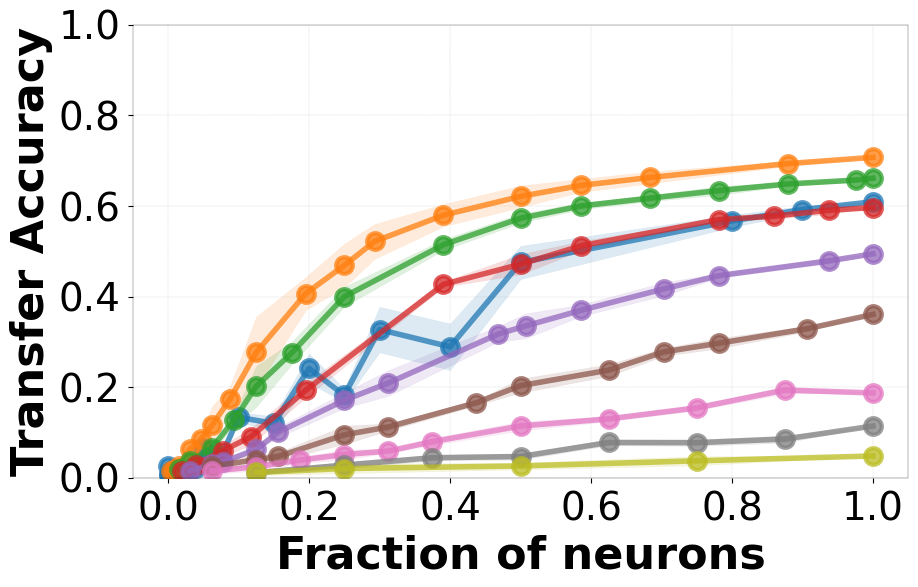

Uploading results in ['results/width_comparison/imagenet'] to contact.mpi-sws.org...
Uploading 12 files to server
copying results/width_comparison/imagenet/resnet50-resnet50_ff8-resnet50_ff16-resnet50_ff32-resnet50_ff64_cifar10_bs_256_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/width_comparison/imagenet/resnet50-resnet50_ff8-resnet50_ff16-resnet50_ff32-resnet50_ff64_cifar10_bs_256_nonrob.png
copying results/width_comparison/imagenet/resnet50-wide_resnet50_2-wide_resnet50_4_cifar10_bs_256_robustl2eps3.png to /home/vnanda/public_html/results/partially_inverted_reps/width_comparison/imagenet/resnet50-wide_resnet50_2-wide_resnet50_4_cifar10_bs_256_robustl2eps3.png
copying results/width_comparison/imagenet/resnet50-resnet50_ff8-resnet50_ff16-resnet50_ff32-resnet50_ff64-resnet50_ff128-resnet50_ff256-resnet50_ff512-resnet50_ff1024_cifar10_bs_256_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/width_comparison/imagenet/resnet50-resnet50_ff8-res

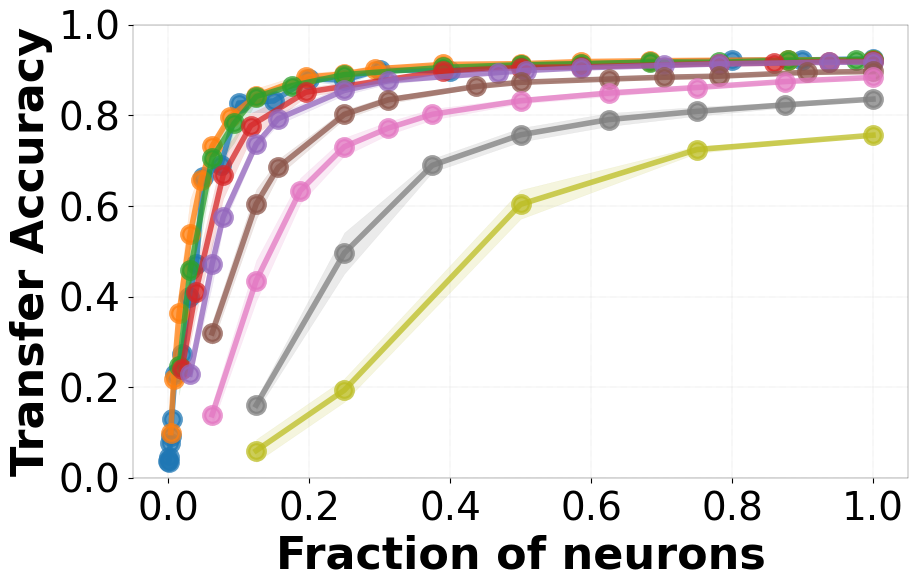

Uploading results in ['results/width_comparison/imagenet'] to contact.mpi-sws.org...
Uploading 12 files to server
copying results/width_comparison/imagenet/resnet50-resnet50_ff8-resnet50_ff16-resnet50_ff32-resnet50_ff64_cifar10_bs_256_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/width_comparison/imagenet/resnet50-resnet50_ff8-resnet50_ff16-resnet50_ff32-resnet50_ff64_cifar10_bs_256_nonrob.png
copying results/width_comparison/imagenet/resnet50-wide_resnet50_2-wide_resnet50_4_cifar10_bs_256_robustl2eps3.png to /home/vnanda/public_html/results/partially_inverted_reps/width_comparison/imagenet/resnet50-wide_resnet50_2-wide_resnet50_4_cifar10_bs_256_robustl2eps3.png
copying results/width_comparison/imagenet/resnet50-resnet50_ff8-resnet50_ff16-resnet50_ff32-resnet50_ff64-resnet50_ff128-resnet50_ff256-resnet50_ff512-resnet50_ff1024_cifar10_bs_256_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/width_comparison/imagenet/resnet50-resnet50_ff8-res

In [6]:
SOURCE_DATASET = 'imagenet'
MODELS = ['resnet50', 'resnet50_ff1024', 'resnet50_ff512', 'resnet50_ff256', 'resnet50_ff128',
          'resnet50_ff64', 'resnet50_ff32', 'resnet50_ff16', 'resnet50_ff8']
FRACTIONS_OR_NUMBERS = [
    None,
    [4,8,16,32,48,64,90,128,200,256,300,400,512,600,700,900,1024],
    [8,16,32,48,64,90,128,200,256,300,350,400,450,500,512],    
    [5,10,20,30,50,100,128,150,200,220,240,256],
    [4,8,10,16,20,32,40,60,65,75,90,100,120,128],    
    [4,8,10,16,20,28,32,40,45,50,58,64],
    [2,4,6,8,10,12,16,20,24,28,32],
    [2,4,6,8,10,12,14,16],
    [1,2,4,6,8]
]
APPEND = 'nonrob'

FT_DATASET = 'cifar10'
results(MODELS, SOURCE_DATASET, FT_DATASET, APPEND, FRACTIONS_OR_NUMBERS)

FT_DATASET = 'cifar100'
results(MODELS, SOURCE_DATASET, FT_DATASET, APPEND, FRACTIONS_OR_NUMBERS)

FT_DATASET = 'flowers'
results(MODELS, SOURCE_DATASET, FT_DATASET, APPEND, FRACTIONS_OR_NUMBERS)

FT_DATASET = 'oxford-iiit-pets'
results(MODELS, SOURCE_DATASET, FT_DATASET, APPEND, FRACTIONS_OR_NUMBERS)